In [1]:
%reset -f

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import os
import pickle
sys.path.append("../utils/")

import numpy as np
import pandas as pd

from scipy.stats import pearsonr

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import LSTM, GRU
from keras.layers.wrappers import TimeDistributed
from keras import regularizers
from keras.optimizers import *

import sklearn as skl
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5.0, 4.0)

from plot_style import *

sys.path.append("util")
from training_tool import *
from vis_tool import *
from data_manipulation_tool import *

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:556: UserWarning: Theano flag device=gpu* (old gpu back-end) only support floatX=float32. You have floatX=float64. Use the new gpu back-end with device=cuda* for that value of floatX.
  warnings.warn(msg)
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 4007)


## Visualization
- Running Parameters
    - frac: [1, 10, 20, 50, 80, 90, 100]
    - set_id: [0, 1, 2, 3, 4]
    - Usage of batch normalization
- Metrics
    - MSE
    - Asym-error
    - Eyes on scatter plot
- What I plot
    - Do not show results with varying set_id
        - MSE and asym-error are averaged over set_id
    - MSE over fraction to see the effect of batch normalization
        - Two lines with frac on x-axis and MSE on y-axis
    - MSE, asym loss over fraction
        - Fraction on x-axis, MES on left y-axis, and asym-loss on right y-axis
    - For each of bset RF and MLP, show scatter plots for every fraction
        - In total, 14 plots are drawn
- Data structure
    - Four 4-dim arrays: (frac, set_id, model, metric)
        - rf_train
        - rf_test
        - mlp_train
        - mlp_test

In [5]:
import itertools

def read_result(machine_id, frac_list, set_id_list, batch_norm, metric_order, trunc_y, subdir=''):
    subdir = subdir + '/' if subdir is not None or subdir is '' else ''

    rf_res_train, rf_res_test = [], []
    mlp_res_train, mlp_res_test = [], []

    for frac, set_id in itertools.product(frac_list, set_id_list):
        rf_all, mlp_all = None, None
        with open('result/{}{}mid{},fr{},set{},ytr{:d}.pkl'.format(subdir, 'batch/' if batch_norm else '', machine_id, frac, set_id, trunc_y), 'r') as f:
            rf_all, mlp_all = pickle.load(f)

        rf_params, rf_X_train, rf_y_train, rf_X_test, rf_y_test, rf_eval_train, rf_eval_test, rf_train_pred, rf_test_pred = rf_all
        mlp_params, mlp_X_train, mlp_y_train, mlp_X_test, mlp_y_test, mlp_eval_train, mlp_eval_test, mlp_train_pred, mlp_test_pred = mlp_all

        rf_res_train.append(eval_as_array(rf_eval_train, metric_order))
        rf_res_test.append(eval_as_array(rf_eval_test, metric_order))
        mlp_res_train.append(eval_as_array(mlp_eval_train, metric_order))
        mlp_res_test.append(eval_as_array(mlp_eval_test, metric_order))
        
    rf_dim = len(frac_list), len(set_id_list), rf_res_train[0].shape[-2], rf_res_train[0].shape[-1]
    mlp_dim = len(frac_list), len(set_id_list), mlp_res_train[0].shape[-2], mlp_res_train[0].shape[-1]

    rf_train = np.mean(np.array(rf_res_train).reshape(rf_dim), axis=1)
    rf_test = np.mean(np.array(rf_res_test).reshape(rf_dim), axis=1)
    mlp_train = np.mean(np.array(mlp_res_train).reshape(mlp_dim), axis=1)
    mlp_test = np.mean(np.array(mlp_res_test).reshape(mlp_dim), axis=1)
    
    return rf_train, rf_test, mlp_train, mlp_test

In [18]:
machine_id = 1
frac_list = [1, 10, 20, 50, 80, 90, 100]
set_id_list = range(5)
batch_norm = False
subdir = 'pure_dense'
trunc_y = True

metric_order = ['mse', 'asym']

rf_train, rf_test, mlp_train, mlp_test = read_result(machine_id, frac_list, set_id_list, batch_norm, metric_order, trunc_y, subdir)

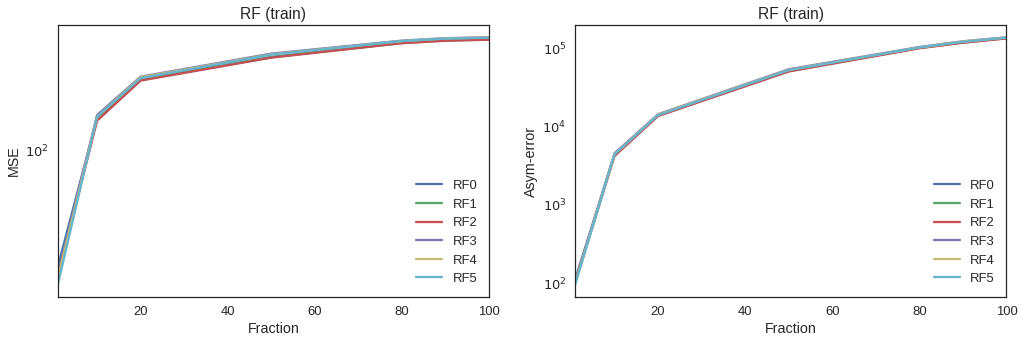

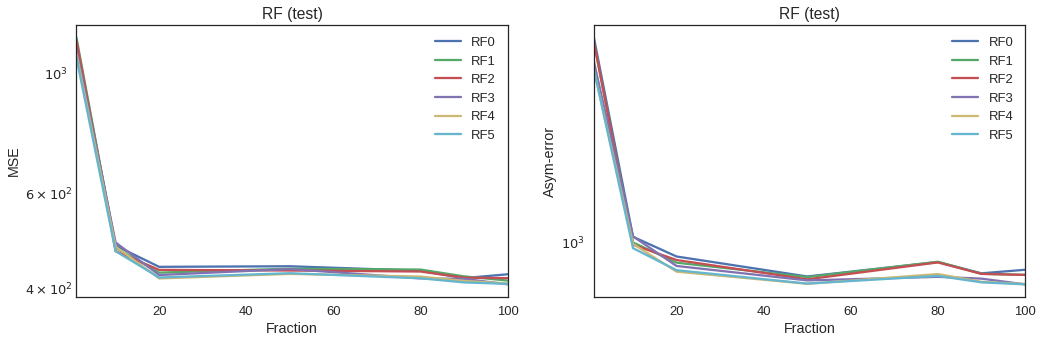

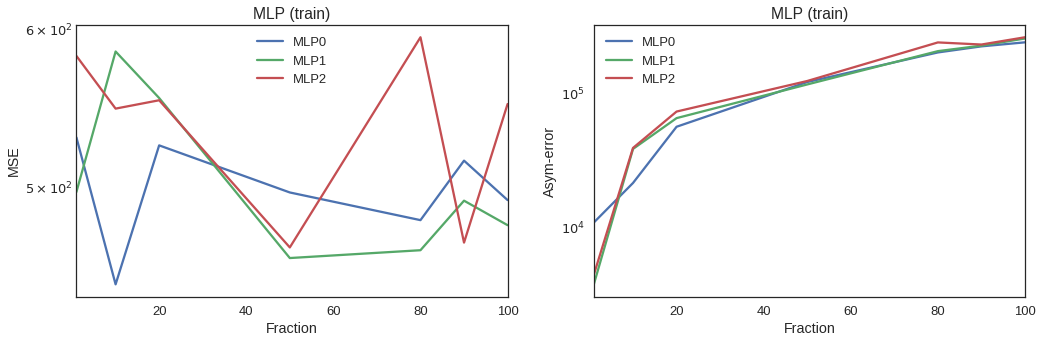

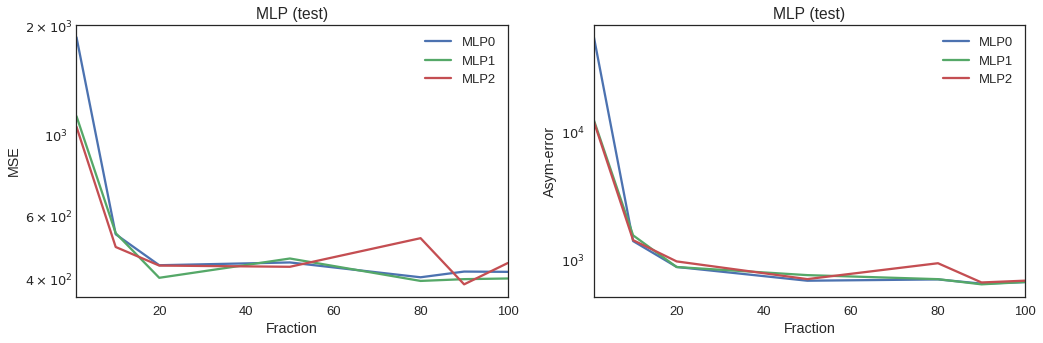

In [19]:
def vis_mse_asym_over_fraction(res, frac_list, model_names, title):
    """
    The dimension of res corresponds to (frac, model, metric)
    The first metric is mse
    The second metric is asym-error
    
    """
    frac_list = np.array(frac_list).reshape(-1,1)
#     res = np.random.randn(7, 6, 2)
    
    df_mse = pd.DataFrame(np.hstack([frac_list,res[:,:,0]]), columns=['frac'] + model_names)
    df_asym = pd.DataFrame(np.hstack([frac_list,res[:,:,1]]), columns=['frac'] + model_names)
    
    _, ax = plt.subplots(1,2)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    ax_mse, ax_asym = ax
    
    def sub_vis(df, ax, ylab):
        for i in range(res.shape[1]):
            df.plot(x='frac', y=model_names[i], ax=ax, figsize=(17,5), logy=True)
        ax.set_title(title)
        ax.set_ylabel(ylab)
        ax.set_xlabel('Fraction')
    
    sub_vis(df_mse, ax_mse, 'MSE')
    sub_vis(df_asym, ax_asym, 'Asym-error')
        
rf_model_names = ['RF{}'.format(i) for i in range(rf_train.shape[-2])]
mlp_model_names = ['MLP{}'.format(i) for i in range(mlp_train.shape[-2])]

vis_mse_asym_over_fraction(rf_train, frac_list, rf_model_names, 'RF (train)')
vis_mse_asym_over_fraction(rf_test, frac_list, rf_model_names, 'RF (test)')
vis_mse_asym_over_fraction(mlp_train, frac_list, mlp_model_names, 'MLP (train)')
vis_mse_asym_over_fraction(mlp_test, frac_list, mlp_model_names, 'MLP (test)')

In [20]:
rf_best_ix = [5]
mlp_best_ix = [0]

def read_y(frac_list, set_id_list, batch_norm, rf_ix, mlp_ix):    
    arr_dim = (len(frac_list), len(set_id_list))
    
    rf_y_train = np.empty(arr_dim, dtype='object')
    rf_y_test = np.empty(arr_dim, dtype='object')
    rf_y_train_pred = np.empty(arr_dim, dtype='object')
    rf_y_test_pred = np.empty(arr_dim, dtype='object')
    
    mlp_y_train = np.empty(arr_dim, dtype='object')
    mlp_y_test = np.empty(arr_dim, dtype='object')
    mlp_y_train_pred = np.empty(arr_dim, dtype='object')
    mlp_y_test_pred = np.empty(arr_dim, dtype='object')

    for (i, frac), (j, set_id) in itertools.product(enumerate(frac_list), enumerate(set_id_list)):
        rf_all, mlp_all = None, None
        with open('result/{}mid{},fr{},set{}.pkl'.format('batch/' if batch_norm else '', machine_id, frac, set_id), 'r') as f:
            rf_all, mlp_all = pickle.load(f)

        _, _, rf_y_train_ij, _, rf_y_test_ij, _, _, rf_y_train_pred_ij, rf_y_test_pred_ij = rf_all
        _, _, mlp_y_train_ij, _, mlp_y_test_ij, _, _, mlp_y_train_pred_ij, mlp_y_test_pred_ij = mlp_all
        
        rf_y_train[i,j] = rf_y_train_ij
        rf_y_test[i,j] = rf_y_test_ij
        rf_y_train_pred[i,j] = rf_y_train_pred_ij
        rf_y_test_pred[i,j] = rf_y_test_pred_ij
        
        mlp_y_train[i,j] = mlp_y_train_ij
        mlp_y_test[i,j] = mlp_y_test_ij
        mlp_y_train_pred[i,j] = mlp_y_train_pred_ij
        mlp_y_test_pred[i,j] = mlp_y_test_pred_ij
    
    return (rf_y_train, rf_y_train_pred, rf_y_test, rf_y_test_pred,
            mlp_y_train, mlp_y_train_pred, mlp_y_test, mlp_y_test_pred)

rf_y_train, rf_y_train_pred, rf_y_test, rf_y_test_pred, mlp_y_train, mlp_y_train_pred, mlp_y_test, mlp_y_test_pred = read_y(frac_list, set_id_list, batch_norm, rf_best_ix, mlp_best_ix)

rf_y_train = rf_y_train[:, 0]
rf_y_test = rf_y_test[:, 0]
rf_y_train_pred = rf_y_train_pred[:, 0]
rf_y_test_pred = rf_y_test_pred[:, 0]

mlp_y_train = mlp_y_train[:, 0]
mlp_y_test = mlp_y_test[:, 0]
mlp_y_train_pred = mlp_y_train_pred[:, 0]
mlp_y_test_pred = mlp_y_test_pred[:, 0]

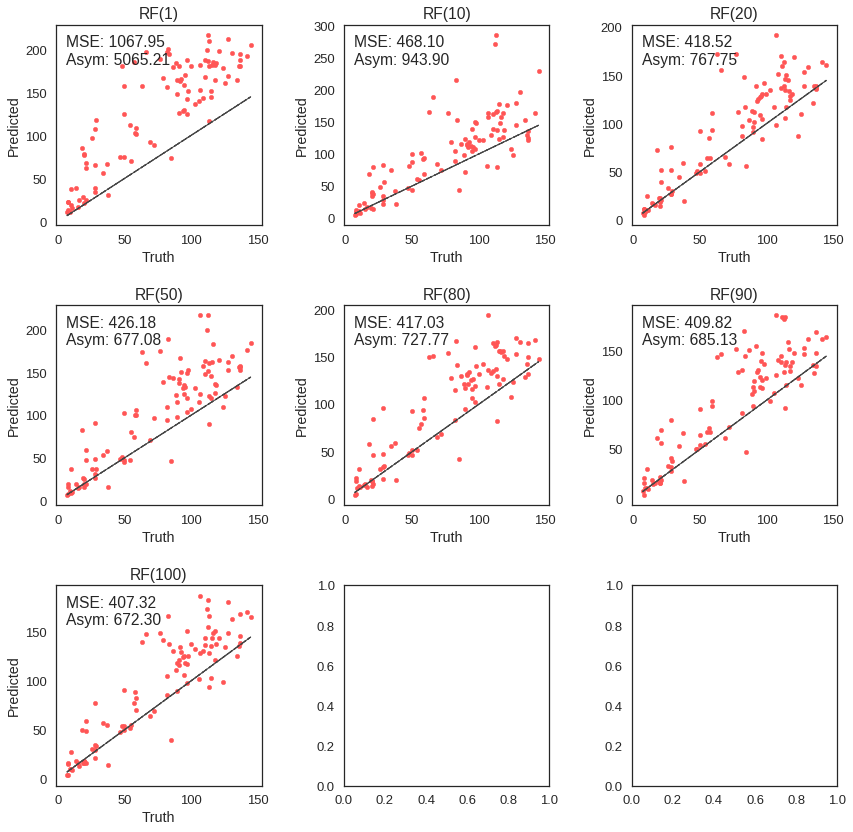

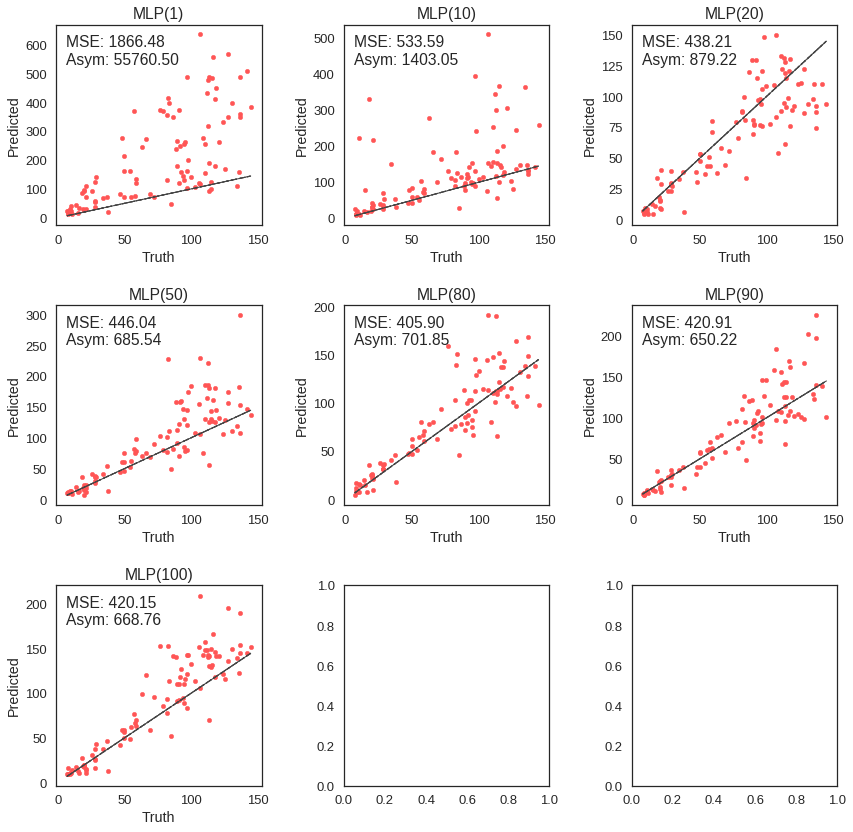

In [21]:
# Plot for set_id = 0, but mse and asym are averaged over set_id

cfg = 'no_time'

rf_df = pd.DataFrame(rf_test[:,rf_best_ix[0],:], columns=['MSE','Asym'])
vis_by_scatter(rf_y_test, rf_y_test_pred, [['RF({})'.format(i)] for i in frac_list], 
               vals=[rf_df.iloc[[i]] for i in range(rf_df.shape[0])], 
               grid_size=(3,3), margins=(0.4,0.4), fig_size=(14,14))
plt.savefig('{}_rf.pdf'.format(cfg), format='pdf')

mlp_df = pd.DataFrame(mlp_test[:,mlp_best_ix[0],:], columns=['MSE','Asym'])
vis_by_scatter(mlp_y_test, mlp_y_test_pred, [['MLP({})'.format(i)] for i in frac_list], 
               vals=[mlp_df.iloc[[i]] for i in range(mlp_df.shape[0])], 
               grid_size=(3,3), margins=(0.4,0.4), fig_size=(14,14))
plt.savefig('{}_mlp.pdf'.format(cfg), format='pdf')

In [ ]:
vv_mse = np.zeros((5,3))
vv_asym = np.zeros((5,3))
for i in range(5):
    for j in range(3):
        vv_mse[i,j] = mean_squared_error(mlp_y_test[3,i], mlp_y_test_pred[3,i][:,j])
        
        dd = mlp_y_test_pred[3,i][:,j] - mlp_y_test[3,i]

        ff = np.zeros_like(dd)
        ff[dd < 0] = -1.0/10
        ff[dd >= 0] = 1.0/13
        vv_asym[i,j] = np.sum(np.exp(ff * dd) - 1)
        
print np.mean(vv_mse, axis=0)
print np.mean(vv_asym, axis=0)

ValueError: operands could not be broadcast together with shapes (100,3) (100,) 

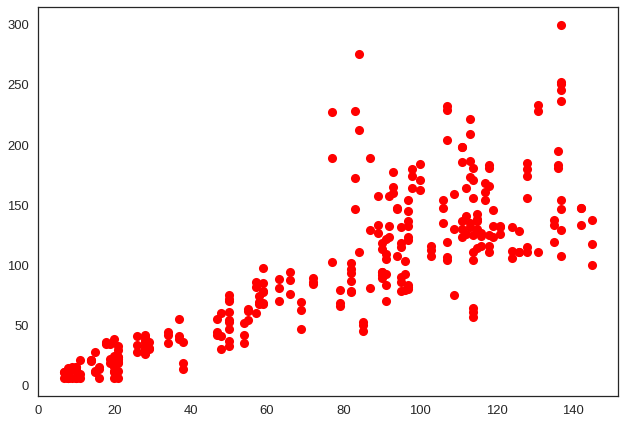

In [85]:
i = 0

plt.plot(mlp_y_test[3], mlp_y_test_pred[3], 'ro')

dd = mlp_y_test_pred[3][:,i] - mlp_y_test[3]

ff = np.zeros_like(dd)
ff[dd < 0] = -1.0/10
ff[dd >= 0] = 1.0/13

print 'asym: ', np.sum(np.exp(ff * dd) - 1)

from sklearn.metrics import mean_squared_error
print mean_squared_error(mlp_y_test[3], mlp_y_test_pred[3])

(7,)

In [76]:
(367583.89521252818  +2584300.1879268195 + 51123.620882557567)/3

1001002.5680073019

In [71]:
mlp_test[3]

array([[   1164.6770152 ,   91158.38166785],
       [   1162.4829683 ,  598450.83223314],
       [   1288.78455437,  653627.9431998 ]])